# Hypothesis Testing

Python notebook for illustrating the concept of Hypothesis Testing and specific test statistics; among them the very useful Kolmogorov-Smirnov test.

The Kolmogorov-Smirnov test (KS test) is a general test to evaluate if two distributions in 1D are the same. This program applies three hypothesis tests to determine, if two distributions are the same:
1. A simple comparison of means.
2. A $\chi^2$-test between histograms.
3. An unbinned KS test

The distributions compared are two unit Gaussians (A and B), where one is then modified by changing:
- Mean
- Width
- Normalisation

The sensitivity of each test is then considered for each of these changes.

### References:
- Barlow: p. 155-156
- __[Wikipedia: Kolmogorov-Smirnov test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test)__
- Though influenced by biostatistics, a good discussion of p-values and their distribution can be found here:
  [How to interpret a p-value histogram?](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/)

### Authors: 
Troels C. Petersen (Niels Bohr Institute)

### Date:    
04-12-2024 (latest update)

***

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats

Set the parameters of the plot:

In [190]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = False
verbose = True

## Set up the experiment:

How many experiments, and how many events in each:

In [191]:
N_exp = 1000
N_events_A = 1000
N_events_B = 1000

Define the two Gaussians to be generated (no difference to begin with!):

In [192]:
dist_mean_A  =  0.0
dist_width_A =  1.0
dist_mean_B  =  0.0
dist_width_B =  1.0

In [193]:
all_p_mean = np.zeros(N_exp)
all_p_chi2 = np.zeros(N_exp)
all_p_ks = np.zeros(N_exp)

fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.close(fig1)

Define the number of bins and the range, initialize empty arrays to store the results in and make an empty figure (to be filled in later):

Loop over how many times we want to run the experiment, and for each calculate the p-value of the two distributions coming from the same underlying PDF (put in calculations yourself):

   0:  p_mean: 0.24370   p_chi2: 0.05538   p_ks: 0.26347
   1:  p_mean: 0.58487   p_chi2: 0.22998   p_ks: 0.46596
   2:  p_mean: 0.95475   p_chi2: 0.30212   p_ks: 0.28780
   3:  p_mean: 0.30509   p_chi2: 0.14109   p_ks: 0.57289
   4:  p_mean: 0.49186   p_chi2: 0.87818   p_ks: 0.91369
   5:  p_mean: 0.51760   p_chi2: 0.96370   p_ks: 0.93577
   6:  p_mean: 0.21644   p_chi2: 0.56190   p_ks: 0.37012
   7:  p_mean: 0.39752   p_chi2: 0.41622   p_ks: 0.79466
   8:  p_mean: 0.95710   p_chi2: 0.97957   p_ks: 0.95422
   9:  p_mean: 0.42288   p_chi2: 0.72773   p_ks: 0.19957
Got to experiment number: 1000


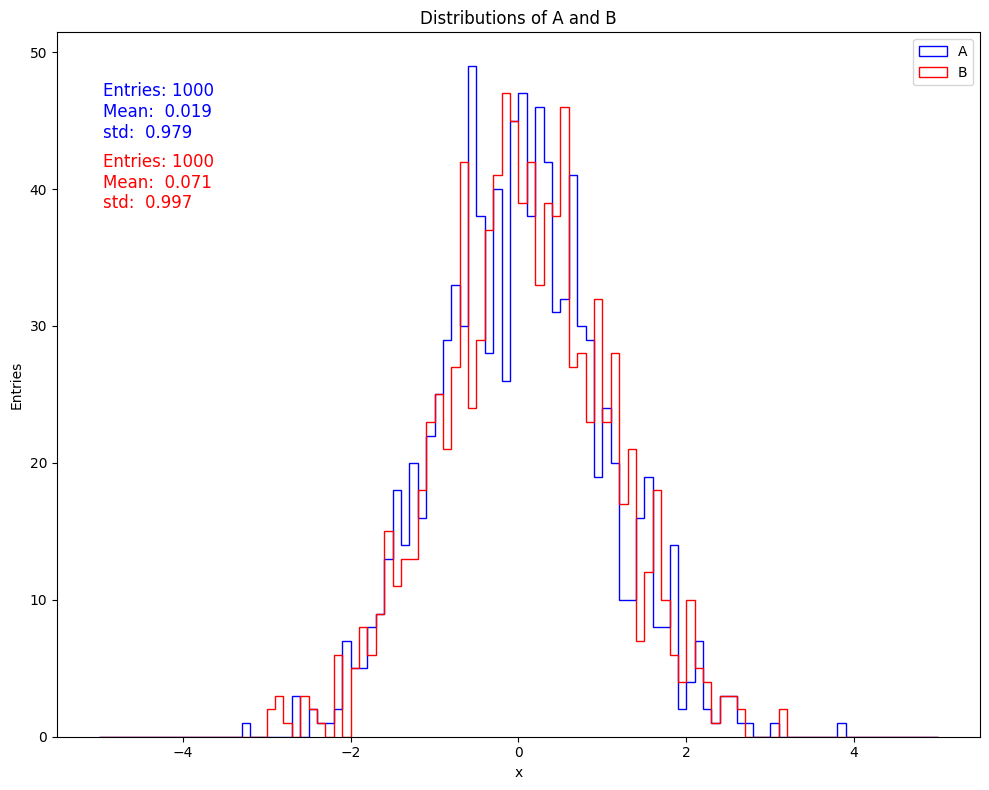

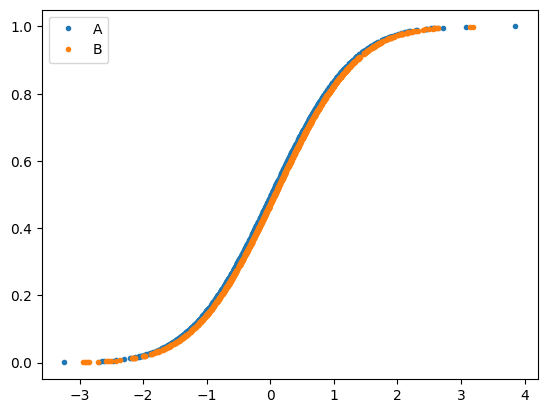

In [194]:
for iexp in range(N_exp):
    if ((iexp+1)%1000 == 0):
        print(f"Got to experiment number: {iexp+1}")

    # Generate data:
    x_A_array = r.normal(dist_mean_A, dist_width_A, N_events_A)
    x_B_array = r.normal(dist_mean_B, dist_width_B, N_events_B)
    
    
    # Test if there is a difference in the mean:
    # ------------------------------------------
    # Calculate mean, standard deviation, and error on mean (sdom):
    mean_A = np.mean(x_A_array)
    std_A  = np.std(x_A_array)
    sdom_A = std_A / np.sqrt(N_events_A)

    mean_B = np.mean(x_B_array)
    std_B  = np.std(x_B_array)
    sdom_B = std_B / np.sqrt(N_events_B)

    # Consider the difference between means in terms of the uncertainty:
    d_mean = mean_A - mean_B
    # How many sigmas are these away from each other? This you should be able to calculate directly.
    z = d_mean / np.sqrt(sdom_A**2 + sdom_B**2)

    # How to turn a number of sigmas into a probability (i.e. p-value)?
    p_mean = stats.norm.sf(abs(z))*2     # Calculate yourself. HINT: "stats.norm.cdf or stats.norm.sf may be useful!"
    # if (verbose and iexp < 10):
    #     print(f"z: {z:7.5f}   p_mean: {p_mean:7.5f}")
    all_p_mean[iexp] = p_mean
    
    
    # Test if there is a difference with the chi2:
    # --------------------------------------------

    N_bins = 50
    hist_A, edges_A = np.histogram(x_A_array, bins=N_bins, range=(dist_mean_A-5*dist_width_A, dist_mean_A+5*dist_width_A))
    hist_B, edges_B = np.histogram(x_B_array, bins=N_bins, range=(dist_mean_B-5*dist_width_B, dist_mean_B+5*dist_width_B))
    mask_A = hist_A > 0
    mask_B = hist_B > 0
    mask_AB = mask_A*mask_B

    #Normalize
 

    # Chi2 Test:
    # Calculate the p-value of the Chi2 between histograms of A and B yourself.
    # chi2,p_chi2 = stats.chisquare(hist_A[mask_AB], f_exp = hist_B[mask_AB])   # Calculate yourself. HINT: "stats.chisquare may be useful!"
    chi2 = np.sum((hist_A[mask_AB] - hist_B[mask_AB])**2 / (hist_B[mask_AB] + hist_A[mask_AB]))
    p_chi2 = stats.chi2.sf(chi2, np.sum(mask_AB))
    # p_chi2 = stats.chi2.sf
    # print(f"chi2: {chi2:7.5f}")
    # print(f"p_chi2: {p_chi2:7.5f}")
    all_p_chi2[iexp] = p_chi2

    
    # Test if there is a difference with the Kolmogorov-Smirnov test on arrays (i.e. unbinned):
    # -----------------------------------------------------------------------------------------
    p_ks = stats.ks_2samp(x_A_array, x_B_array)[1]    # Fortunately, the K-S test is implemented in stats!
    all_p_ks[iexp] = p_ks


    # Print the results for the first 10 experiments
    if (verbose and iexp < 10) :
      print(f"{iexp:4d}:  p_mean: {p_mean:7.5f}   p_chi2: {p_chi2:7.5f}   p_ks: {p_ks:7.5f}")

    
    # In case one wants to plot the distribution for visual inspection:
    if (iexp == 0):
        ax1.hist(x_A_array, bins=100, range=(dist_mean_A-5*dist_width_A, dist_mean_A+5*dist_width_A), histtype='step', color='b', label='A')
        stats_info_A = [f"Entries: {len(x_A_array)}",
                        f"Mean: {mean_A:6.3f}",
                        f"std: {std_A:6.3f}"]
        ax1.text(0.05, 0.85, '\n'.join(stats_info_A), fontsize = 12, color = 'b', transform=ax1.transAxes)
        ax1.hist(x_B_array, bins=100, range=(dist_mean_B-5*dist_width_B, dist_mean_B+5*dist_width_B), histtype='step', color='r', label='B')
        stats_info_B = [f"Entries: {len(x_B_array)}",
                        f"Mean: {mean_B:6.3f}",
                        f"std: {std_B:6.3f}"]
        ax1.text(0.05, 0.75, '\n'.join(stats_info_B), fontsize = 12, color = 'r', transform=ax1.transAxes)
        ax1.legend()
        ax1.set_xlabel('x')
        ax1.set_ylabel('Entries')
        ax1.set_title('Distributions of A and B')
        fig1.tight_layout()

        cdf_A = stats.norm.cdf(x_A_array, loc=mean_A, scale=dist_width_A)
        cdf_B = stats.norm.cdf(x_B_array, loc=mean_B, scale=dist_width_B)

        plt.errorbar(x_A_array, cdf_A, fmt = '.', label='A')
        plt.errorbar(x_B_array, cdf_B, fmt = '.', label='B')
        plt.legend()

fig1

## Show the distribution of hypothesis test p-values:

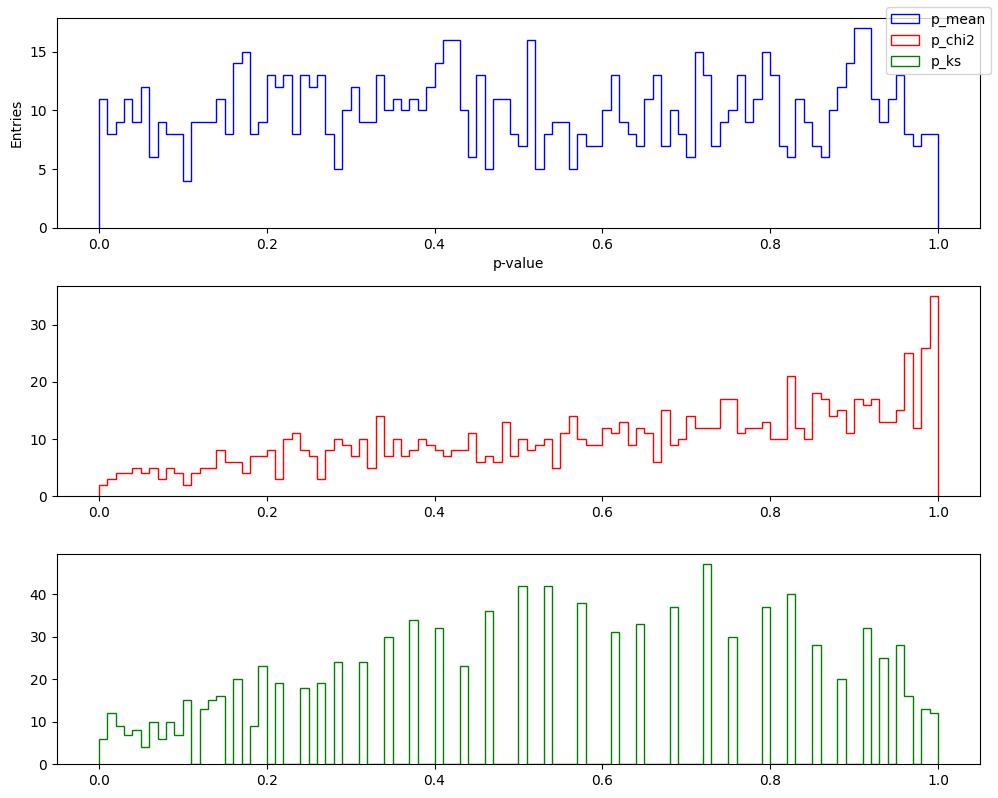

In [197]:
N_bins = 100

if (N_exp > 1):
    fig2, ax2 = plt.subplots(nrows=3, figsize=(10, 8))

    ax2[0].hist(all_p_mean, bins=N_bins, range=(0, 1), histtype='step', color='b', label='p_mean')

    ax2[1].hist(all_p_chi2, bins=N_bins, range=(0, 1), histtype='step', color='r', label='p_chi2')

    ax2[2].hist(all_p_ks, bins=N_bins, range=(0, 1), histtype='step', color='g', label='p_ks')

    ax2[0].set_xlabel('p-value')
    ax2[0].set_ylabel('Entries')

    fig2.legend()

    fig2.tight_layout()

# Questions:

1. First run the program with one experiment (N_exp = 1) to display the two distributions A and B, when:
    - They are the same.
    - The mean of A is increased (to e.g. 0.1).
    - The width of A is enlarged (to e.g. 1.2).
    - The normalisation of A is increased.

Get a feel for how much you need to change the distribution, before you can _by eye_ see that they are not the same. I.e. can you see any difference, if `mean_A` $= 0.1$? Or how about $0.2$? How do you quantify this and when do you start to doubt? And how about `width_A` $= 1.1$? Or $1.2$? Again, can you see it by eye? Finally, try to put $110$ events into A. Is that visible? How about $120$?<br>
When you have an idea about when you can see effects by eye, now check if you see an impact in the p-values?
Also, change the number of events in A and B, and see if you ability (of the p-values ability) to distinguish grows as sqrt(N).

2. Could you for the test of the means have calculated how much of a change in the mean is needed for a difference to be statistically significant? Do so, and see if it somewhat matches your calculation/estimate from above!


3. Now run the tests 1000 times, where A and B are unit Gaussians and thus identical. How should the distributions of the test probabilities come out? And is this the case, approximately? If not, think of reasons for this, and what could be a remedy. HINT: Large statistics is always easier!


4. Repeat the changes in question 1), and see which tests "reacts" most to these modifications. How much of a change in the mean is required for 95% of the tests (of each kind) to give a probability below 5%? How much is required for the width? And the norm?


5. Possibly try to test different distributions than the Gaussian one (e.g. exponential, uniform, etc.), and see how the tests performs.

NOTE: The Kolmogorov-Smirnov test has the great advantage that it can handle ANY distribution (even the Cauchy distribution - remind yourself of that one!). The reason is, that it doesn't care about any PDF, nor how far out an outlier is. It is just a matter of the difference in integrals between the two functions.


## Advanced:

6. Obviously, the test of the means is not sensitive to a change in the width. Make such a test yourself by calculating the widths and the uncertainty on the widths (or perhaps try the F-test!). Note that in a (unit) Gaussian the uncertainty on the width is of the same order as that of the means!


## Very advanced:
7. Implement in python the following tests:
     - Lilliefors test
     - Shapiro-Wilk test
     - Anderson-Darling test
     - Cramer-von-Mises test
     - Jarque-Bera test
     - Kuiper's test
     - Mann-Whitney-Wilcoxon test
     - Siegel-Tukey test
     
and quantify under various conditions and datasets the power of each and the correlation among them. Write it up, and send it to a statistics journal. :-)

# Learning points:

The exercise should give you a good idea about the process of hypothesis testing, namely that you calculate a p-value, which under the null hypothesis is uniformly distributed.

You should be aware that in this exercise, we "play Gods" and repeat a perfect experiment over and over, to see the changes in the p-value distribution, when we change one of the input distributions. **However, when you have real data, you will only get a single p-value!** And you should be in a position, where you trust (and have perhaps tested using simulation) that the p-value really is uniform for the null hypothesis, and thus points to something "non-null", if very low.

The three tests (means, chi2, and KS) are some of the very standard approaches, but there are certainly also others.